In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from math import floor
#import Test
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

# SEQUENCE_LENGTH = 8
# PREDICTION_DELTA = 4
VIDEO_LEN_LIMIT = 50

MIN_VIEWS = 100 #1000 ?

BATCH_SIZE = 100
TRAIN_STEPS = 700000
LEARNING_RATE = 2e-3
STABLE_DELTA = 0.69 # 2 views


# fig, ax = plt.subplots()
# plt.figure(figsize=(12, 5))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))


def rolling_window(a, window, lablesShift):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)

    data = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    lables = a[window - 1 + lablesShift::1]
    return data[:-lablesShift], lables


def LoadData(name):
    df = pd.read_csv('data/' + name + '.csv',
                     index_col=['date'],
                     dtype={"video_id": object, "views": np.float64},
                     parse_dates=['date'])
    return df


def GetNextBatch(inputs, lables, batchId):
    batchId = batchId % len(inputs)
    startIndex = batchId * BATCH_SIZE
    endIndex = (batchId + 1) * BATCH_SIZE
    if (len(inputs) < endIndex):
        startIndex = 0
        endIndex = BATCH_SIZE

    return (inputs[startIndex:endIndex], lables[startIndex:endIndex])


def DfToList(df):
    listOfVideoViews = list(df.groupby('video_id')['views'].apply(pd.DataFrame.as_matrix))
    return listOfVideoViews

def ExtractSequenes(listOfVideoViews, seqLen, predDelta, minLen, maxLen):
    if (not minLen):
        minLen = 0

    if (not maxLen):
        maxLen = 10e+10
    
    koefs = []
    datas = []
    lables = []
    maxV = 0
    maxI = 0

    for i in range(len(listOfVideoViews)):
        s = listOfVideoViews[i]
        if (len(s) > minLen and len(s) < maxLen):


            # if(i == 297553):
            #     print("target")
            daysToRemove = 0
            passed = False

            for j in range(len(s)):
                if (s[j] > 20):
                    daysToRemove = j
                    passed = True
                    break

            if (passed and (len(s) - daysToRemove > minLen)):
                realDaysToRemove = max(daysToRemove, 30)
                data, lable = rolling_window(s[realDaysToRemove:], window=seqLen, lablesShift=predDelta)
                # if(data.min() < 20):
                #     print("bad")

                datas.extend(data)
                lables.extend(lable)
                
#                 dataMean = np.mean(data)
#                 koef = np.log(lable) / np.log(dataMean)
#                 koefs.append(koef)


    datas_res = np.log(datas)
    lables_res = np.log(lables)

    datas_res = np.clip(datas_res, a_min = STABLE_DELTA, a_max = 99999999999)
    lables_res = np.clip(lables_res, a_min = STABLE_DELTA, a_max = 99999999999)
    
#     print(len(koefs))
#     print(np.mean(koefs))
#     plt.plot(koefs)
#     plt.show()
#     for i in range(len(datas_res)):
#         data = datas_res[i]
#         lable = lables_res[i]

#         koef = lable / data
#         curMax = koef.max()
#         if (curMax > maxV):
#             maxV = curMax
#             maxI = i

#         if (koef.max() > 10000):
#             print("Bad")

    return datas_res, lables_res


def TrainModel(train_inputs, train_lables, test_inputs, test_lables, SEQUENCE_LENGTH):
    #train_inputs, train_lables = shuffle(train_inputs, train_lables)

    # if (absNorms is not None):
    #     train_inputs /= absNorms

    X = tf.placeholder("float", shape=(None, SEQUENCE_LENGTH), name="Inputs")  # , COLUMNS_COUNT
    Y = tf.placeholder("float", shape=(None, 1), name="Outputs")

    W = tf.Variable(tf.ones([SEQUENCE_LENGTH, 1]), name="weight")  # COLUMNS_COUNT

    pred = tf.reduce_sum(tf.matmul(X, W), axis=1)
    loss = tf.reduce_mean(tf.square(pred / Y - 1))
    grads = tf.gradients(loss, [W])[0]

    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    losses = []

    for step in range(TRAIN_STEPS):
        training_data, lables = GetNextBatch(train_inputs, train_lables, step)
        inputs = np.reshape(training_data, (BATCH_SIZE, SEQUENCE_LENGTH))
        output = np.reshape(lables, (BATCH_SIZE, 1))

        _, curLoss = sess.run([train, loss], feed_dict={X: inputs, Y: output})
        losses.append(curLoss)

        if (step % 9000 == 0):
            mn = np.mean(losses[len(losses) - 9000: len(losses)])
            #print("loss: ", mn)
            #print("W = ", sess.run(W))

    test_lables = np.reshape(test_lables, (len(test_lables), 1))
    predictTest = sess.run(pred, feed_dict={X: test_inputs})

    originalPredicted = np.exp(np.array(predictTest))

    # if (absNorms is not None):
    #     originalPredicted *= absNorms

    originalTestOutputs = np.exp(test_lables.ravel())  # Why exp here ???!!
    rse = ((originalPredicted / originalTestOutputs) - 1) ** 2
    mapeAr = abs(1 - originalPredicted / originalTestOutputs)
    finalW = sess.run(W)
    print("Final W = ", finalW)

#     print("W = ", sess.run(W))

#     tr_inputs = np.reshape(train_inputs, (len(train_inputs), SEQUENCE_LENGTH))
#     tr_output = np.reshape(train_lables, (len(train_lables), 1))
#     trainLoss = sess.run(loss, feed_dict={X: tr_inputs[:30000], Y: tr_output[:30000]})
#     print("train loss", trainLoss)

#     tst_inputs = np.reshape(test_inputs, (len(test_inputs), SEQUENCE_LENGTH))
#     tst_output = np.reshape(test_lables, (len(test_lables), 1))
#     testLoss = sess.run(loss, feed_dict={X: tst_inputs[:30000], Y: tst_output[:30000]})
#     print("testLoss loss", testLoss)

#     predictTrain = sess.run(pred, feed_dict={X: tr_inputs})
#     originalTrainPredicted = np.exp(np.array(predictTrain))
#     originalTrainOutputs = np.exp(train_lables.ravel())
#     mapeAr_train = abs(1 - originalTrainPredicted / originalTrainOutputs)
#     print("mapeAr_train mean", mapeAr_train.mean())

#     mn = pd.rolling_mean(np.array(losses), 500)
#     plt.plot(mn[500:])
#     plt.show()

    return mapeAr.mean(), mapeAr.std(), finalW


def ExtractNormilizedSequences(listOfVideoViews, seqLen, minLen, maxLen):
    if (not minLen):
        minLen = 0

    if (not maxLen):
        maxLen = 10e+10

    datas = []
    lables = []
    for s in listOfVideoViews:
        if (len(s) > minLen and len(s) < maxLen):
            data = np.array(s[:seqLen])
            maxData = np.max(data)  # data[seqLen - 1]
            if (maxData > 0):
                data = data / maxData
                datas.append(data)

    return np.array(datas)


def TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLength, lableShift, minLimit, maxLimit):
    train_inputs, train_lables = ExtractSequenes(listOfTrainVideoViews, seqLength, lableShift, minLimit, maxLimit)
    
    test_inputs, test_lables = ExtractSequenes(listOfTestVideoViews, seqLength, lableShift, minLimit, maxLimit)
    mapeMean, mapeVar, finalW = TrainModel(train_inputs, train_lables, test_inputs, test_lables, seqLength)
    return mapeMean, mapeVar, finalW

def GetRegrouppedViews(trainDf, testDf):
    return DfToList(trainDf), DfToList(testDf)


def AddTrend(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")


def Plot(dataL, step=1):
    rseMean, rseVar, mapeMean, mapeVar = zip(*dataL)
    # calc the trendline
    x = np.arange(start=0, stop=len(mapeMean), step=step)
    y = mapeMean
    plt.title('MAPE mean')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    AddTrend(x, y)
    plt.plot(x, y)
    plt.show()

    x = np.arange(len(mapeVar))
    y = mapeVar
    plt.title('MAPE var')
    AddTrend(x, y)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.plot(x, y)
    plt.show()

    minInd = np.argmin(mapeMean)

    print("Min at index: {}; val: {}%".format(minInd, x[minInd] * 100.0))


def TestSeqLenPerf(listOfTrainVideoViews, listOfTestVideoViews, predDelta, maxSeqLen, seqLenStep=1, minLimit=None,
                   maxLimit=None):
    dataL = []

    for seqLen in range(1, maxSeqLen, seqLenStep):
        print("{} from {}".format(seqLen, maxSeqLen), end="\r")
        statsTuple = TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

    return dataL


def TestSeqPredDeltaPerf(listOfTrainVideoViews, listOfTestVideoViews, seqLen, maxPredDelta, predDeltaStep=1,
                         minLimit=None, maxLimit=None):
    dataL = []

    for predDelta in range(1, maxPredDelta, predDeltaStep):
        #print("{} from {}".format(predDelta, maxPredDelta), end="\r")
        print("{} from {}".format(predDelta, maxPredDelta))
        statsTuple = TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

    return dataL

def GetDeltasStats(listOfTrainVideoViews, listOfTestVideoViews, seqLen, maxPredDelta, predDeltaStep=1,
                         minLimit=None, maxLimit=None):
    dataL = []

    for predDelta in range(1, maxPredDelta, predDeltaStep):
        print("{} from {}".format(predDelta, maxPredDelta))
        statsTuple = TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

    return dataL


In [5]:
trainDf = LoadData('train')
testDf = LoadData('validation')

In [6]:
trainViewsD, testViewsD = GetRegrouppedViews(trainDf, testDf)

In [ ]:
start = time.time()

statsTuple4 = TestParams(trainViewsD, testViewsD, 26, 120, minLimit = 180, maxLimit = None)
print(statsTuple4)

end = time.time()
print("Elapsed: ", end - start)

In [7]:
start = time.time()

statsTuple4 = TestParams(trainViewsD, testViewsD, 7, 30, minLimit = 180, maxLimit = None)
print(statsTuple4)

end = time.time()
print("Elapsed: ", end - start)

Final W =  [[ 0.14267205]
 [ 0.14270554]
 [ 0.14274073]
 [ 0.1427795 ]
 [ 0.14281748]
 [ 0.14285892]
 [ 0.14290227]]
(0.0093643633792315252, 0.0010133639779925558, 0.061539533548144308, 0.0055772491899083515)
Elapsed:  20.334311723709106


In [6]:
statsTuple4 = TestParams(trainViewsD, testViewsD, 26, 30, minLimit = 180, maxLimit = None)
print(statsTuple4)

Final W =  [[ 0.02739497]
 [ 0.0283144 ]
 [ 0.02922882]
 [ 0.03013889]
 [ 0.03104594]
 [ 0.03194813]
 [ 0.03284737]
 [ 0.0337435 ]
 [ 0.03463593]
 [ 0.03552384]
 [ 0.03640951]
 [ 0.03729248]
 [ 0.03817254]
 [ 0.0390501 ]
 [ 0.03992458]
 [ 0.0407968 ]
 [ 0.041665  ]
 [ 0.04253018]
 [ 0.04339216]
 [ 0.04425192]
 [ 0.04510824]
 [ 0.04595961]
 [ 0.04680723]
 [ 0.04765006]
 [ 0.04848742]
 [ 0.04932073]]
(0.054591405656834124, 0.0065590371560504636, array([[ 0.02739497],
       [ 0.0283144 ],
       [ 0.02922882],
       [ 0.03013889],
       [ 0.03104594],
       [ 0.03194813],
       [ 0.03284737],
       [ 0.0337435 ],
       [ 0.03463593],
       [ 0.03552384],
       [ 0.03640951],
       [ 0.03729248],
       [ 0.03817254],
       [ 0.0390501 ],
       [ 0.03992458],
       [ 0.0407968 ],
       [ 0.041665  ],
       [ 0.04253018],
       [ 0.04339216],
       [ 0.04425192],
       [ 0.04510824],
       [ 0.04595961],
       [ 0.04680723],
       [ 0.04765006],
       [ 0.04848742],
  

In [ ]:
start = time.time()

deltaStats = GetDeltasStats(trainViewsD, testViewsD, seqLen = 26,
                                    maxPredDelta = 120, predDeltaStep = 1, minLimit = 180, maxLimit = None)

end = time.time()
print("Elapsed: ", end - start)

1 from 120
Final W =  [[-0.01704628]
 [-0.0118172 ]
 [-0.00698762]
 [-0.00221506]
 [ 0.00234871]
 [ 0.00703329]
 [ 0.01168653]
 [ 0.01640361]
 [ 0.0213945 ]
 [ 0.02582366]
 [ 0.03007046]
 [ 0.03417314]
 [ 0.03824677]
 [ 0.04239038]
 [ 0.04656124]
 [ 0.05070356]
 [ 0.05485644]
 [ 0.05900588]
 [ 0.06263857]
 [ 0.06623467]
 [ 0.06937527]
 [ 0.07329607]
 [ 0.07680875]
 [ 0.08070105]
 [ 0.08427545]
 [ 0.08677129]]
2 from 120
Final W =  [[-0.01698972]
 [-0.01176979]
 [-0.00694091]
 [-0.0021804 ]
 [ 0.00237853]
 [ 0.00705283]
 [ 0.01170347]
 [ 0.01640511]
 [ 0.02139563]
 [ 0.02582463]
 [ 0.03006787]
 [ 0.03417578]
 [ 0.0382494 ]
 [ 0.04239688]
 [ 0.0465714 ]
 [ 0.05071751]
 [ 0.05487245]
 [ 0.05902208]
 [ 0.06263655]
 [ 0.06623102]
 [ 0.06939635]
 [ 0.07331023]
 [ 0.07682464]
 [ 0.08072777]
 [ 0.08429224]
 [ 0.08676994]]
3 from 120
Final W =  [[-0.01713341]
 [-0.01190464]
 [-0.0070661 ]
 [-0.00229708]
 [ 0.00227629]
 [ 0.00695591]
 [ 0.01162778]
 [ 0.01633363]
 [ 0.02133904]
 [ 0.02578734]
 [

Final W =  [[-0.02009245]
 [-0.01461934]
 [-0.00951202]
 [-0.00447367]
 [ 0.00047297]
 [ 0.00535236]
 [ 0.01031677]
 [ 0.0153358 ]
 [ 0.02049838]
 [ 0.02530843]
 [ 0.02971249]
 [ 0.03419224]
 [ 0.03843374]
 [ 0.04287992]
 [ 0.04733476]
 [ 0.05178516]
 [ 0.05622774]
 [ 0.06045878]
 [ 0.06437882]
 [ 0.0676523 ]
 [ 0.07171877]
 [ 0.07576546]
 [ 0.07963239]
 [ 0.08385755]
 [ 0.087198  ]
 [ 0.09012225]]
22 from 120
Final W =  [[-0.02037749]
 [-0.01487959]
 [-0.00974464]
 [-0.00468888]
 [ 0.00029093]
 [ 0.0051913 ]
 [ 0.01017043]
 [ 0.01522765]
 [ 0.02040401]
 [ 0.02524502]
 [ 0.02967147]
 [ 0.03418745]
 [ 0.0384388 ]
 [ 0.04291163]
 [ 0.04738927]
 [ 0.05186334]
 [ 0.05633201]
 [ 0.06056591]
 [ 0.06452522]
 [ 0.06779087]
 [ 0.07190851]
 [ 0.0759752 ]
 [ 0.07988665]
 [ 0.08409724]
 [ 0.08744968]
 [ 0.09042504]]
23 from 120


In [17]:
mapeAr, mapeVar, finalW = zip(*deltaStats)

In [ ]:
with open('deltaStats_2', 'wb') as handle:
    pickle.dump(deltaStats, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
Plot(dSeqPred)

In [ ]:
# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
seqLen = 26
    
dataL = []
maxPredDelta = 260
minLimit = 360
maxLimit = None

for predDelta in range(211, maxPredDelta, 1):
        print("{} from {}".format(predDelta, maxPredDelta))
        statsTuple = TestParams(trainViewsD, trainViewsD, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

Plot(dataL)

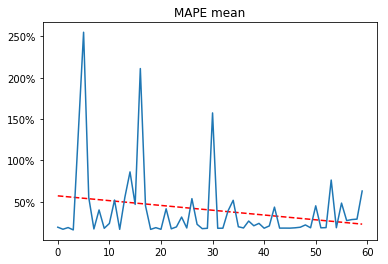

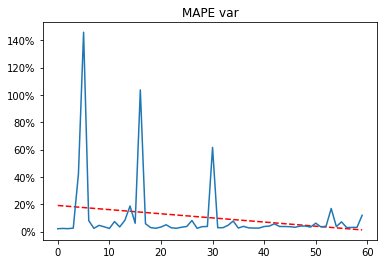

Min at index: 3; val: 300.0%


In [120]:
Plot(dataL)

In [32]:
dSeqPred = TestSeqLenPerf(trainViewsD, testViewsD, 60, 30, seqLenStep=1, minLimit=360, 
                   maxLimit=None)

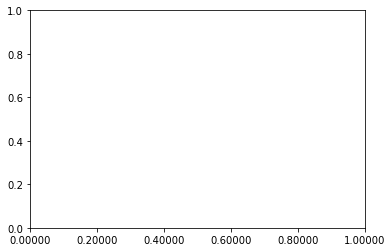

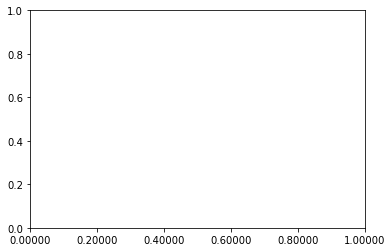

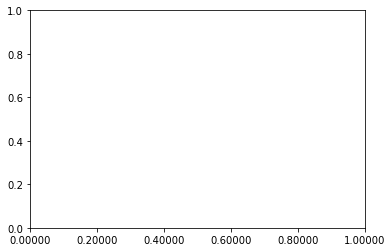

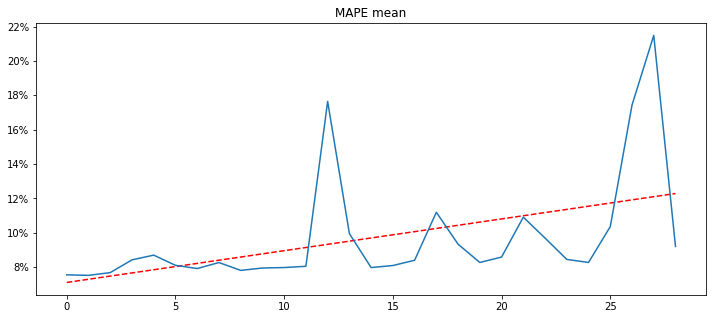

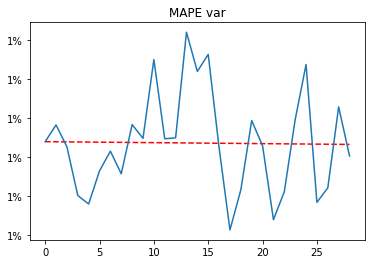

Min at index: 1; val: 100.0%


In [33]:
Plot(dSeqPred)

In [25]:
rseMean, rseVar, mapeMean, mapeVar = zip(*dSeqPred)
print(mapeMean[56])
# plt.plot(mapeMean)
# plt.show()

1.51113304813


In [30]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 30, 56, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.061632200314191886, 0.0028646838575015648, 0.2240592246728966, 0.011429664153172338)


In [53]:
rseMean, rseVar, mapeMean, mapeVar = zip(*dSeqPred)
print(mapeMean)

(0.023438504552296079, 0.053837229848589199, 0.093689122233756125, 0.10642736050002977, 0.92067736995318006, 0.14364342556029261, 0.50134173005886529, 0.1893877461819122, 0.21482854856720371, 0.44875991113456348, 0.2340103151192077, 0.3072964315523467)


In [47]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 150, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.012397810898559809, 0.002382165213488433, 0.058666371992402704, 0.0089560676958088392)


In [48]:
print(TestParams(trainViewsD, testViewsD, 26, 30 * 2, minLimit = 360, maxLimit = None))

(0.024383772052560017, 0.0054264797405616273, 0.090952492888184591, 0.016111416089984752)


In [110]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 30 * 3, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.030970941850745098, 0.0048697365159474414, 0.13457778638812662, 0.012859761261616854)


In [109]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 30 * 4, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.0399638883950795, 0.0092419259572782894, 0.13098310477646688, 0.022807314658196597)


In [108]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 30 * 5, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.077016989098839805, 0.0091957638704973053, 0.23595655215083969, 0.021341494595927879)


In [107]:
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 30 * 6, minLimit = 360, maxLimit = None)
print(statsTuple2)


(0.068557417520085165, 0.017340568638434969, 0.17840531895923173, 0.036728959687139968)


In [123]:
# Bad perfomance here
statsTuple2 = TestParams(trainViewsD, testViewsD, 26, 215, minLimit = 360, maxLimit = None)
print(statsTuple2)

(0.07703924638005244, 0.020727509405807414, 0.19300380413119667, 0.039788777970939097)


In [17]:
badPErf = TestSeqLenPerf(trainViewsD, testViewsD, predDelta = 26 * 10, maxSeqLen = 30,
                   seqLenStep = 3, minLimit = 360, maxLimit = None)

loss:  0.0170344
loss:  0.00422531
loss:  0.00394915
loss:  0.0036728
loss:  0.00300384
loss:  0.00265028
loss:  0.00279299
loss:  0.004187
loss:  0.00343638
loss:  0.00298608
loss:  6.43893
loss:  0.0332543
loss:  0.00366462
loss:  0.00339968
loss:  0.00269493
loss:  0.0026204
loss:  0.00283008
loss:  0.00392323
loss:  0.00304039
loss:  0.00296548
loss:  27.3094
loss:  0.0714312
loss:  0.00377397
loss:  0.00312758
loss:  0.00245757
loss:  0.00260615
loss:  0.0028427
loss:  0.00363083
loss:  0.00287138
loss:  0.00294465
loss:  62.8535
loss:  0.109294
loss:  0.00371296
loss:  0.00287592
loss:  0.00233111
loss:  0.00249051
loss:  0.00279129
loss:  0.00337624
loss:  0.00259179
loss:  0.00270501
loss:  113.239
loss:  0.146682
loss:  0.00341543
loss:  0.00284391
loss:  0.00217604
loss:  0.00250562
loss:  0.00287981
loss:  0.00298514
loss:  0.00229534
loss:  0.00263769
loss:  178.591
loss:  0.182613
loss:  0.00363664
loss:  0.00254299
loss:  0.00206939
loss:  0.00231708
loss:  0.00270976
los

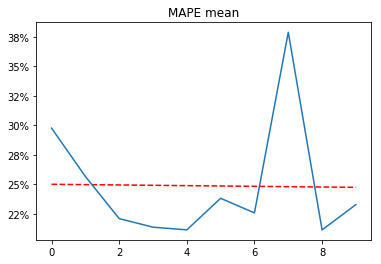

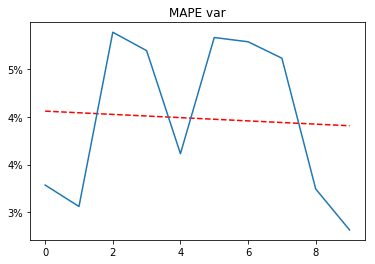

Min at index: 8; val: 800.0%


In [18]:
Plot(badPErf)

In [19]:
badPErf[4]

(0.085841099333417395,
 0.026713412648721103,
 0.21143140017591774,
 0.041137862353068343)

In [20]:
# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
dSeqPred_oneD = TestSeqPredDeltaPerf(trainViewsD, testViewsD, seqLen = 1,
                                    maxPredDelta = 360, predDeltaStep = 30, minLimit = 360, maxLimit = None)

loss:  0.00160499
loss:  0.00117175
loss:  0.00156658
loss:  0.000814553
loss:  0.00148469
loss:  0.000988981
loss:  0.00121203
loss:  0.00102616
loss:  0.000867133
loss:  0.00136037
loss:  0.00467841
loss:  0.00113235
loss:  0.00169052
loss:  0.00101037
loss:  0.0013561
loss:  0.00111469
loss:  0.00102777
loss:  0.00103619
loss:  0.000966834
loss:  0.00136362
loss:  0.00765718
loss:  0.00140833
loss:  0.00193736
loss:  0.00140016
loss:  0.00154107
loss:  0.00133559
loss:  0.00107899
loss:  0.00126823
loss:  0.00153833
loss:  0.00138153
loss:  0.00992685
loss:  0.00171275
loss:  0.00226059
loss:  0.0018131
loss:  0.00166745
loss:  0.00163684
loss:  0.00128192
loss:  0.00141699
loss:  0.00173116
loss:  0.00178941
loss:  0.0118223
loss:  0.00202466
loss:  0.00256733
loss:  0.00215707
loss:  0.00183336
loss:  0.00189412
loss:  0.00145562
loss:  0.00172419
loss:  0.00196609
loss:  0.00225377
loss:  0.0135655
loss:  0.00235609
loss:  0.00293284
loss:  0.00252853
loss:  0.00196163
loss:  0.0

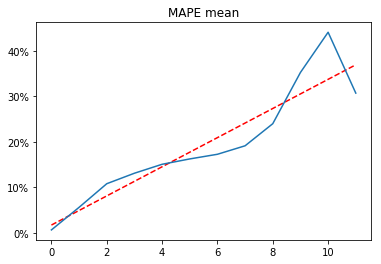

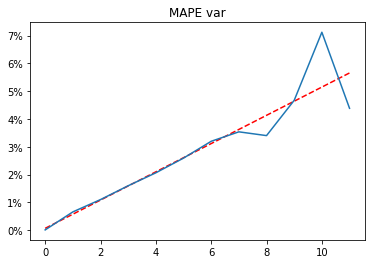

Min at index: 0; val: 0.0%


In [21]:
Plot(dSeqPred_oneD)

In [22]:
np.array(dSeqPred_oneD)[:,2][10]

0.44120838174683408

In [23]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 8 * 30, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

loss:  0.0165018
loss:  0.00395257
loss:  0.00361027
loss:  0.00363439
loss:  0.00281947
loss:  0.00224416
loss:  0.00293108
loss:  0.00321229
loss:  0.00379484
loss:  0.00263574
(0.089464939553247205, 0.022844451636032589, 0.23526451906510945, 0.034115545622310006)


In [24]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 9 * 30, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

loss:  0.0172888
loss:  0.00436309
loss:  0.00411329
loss:  0.00382762
loss:  0.00293512
loss:  0.00302122
loss:  0.00310927
loss:  0.0040698
loss:  0.0033267
loss:  0.00354596
(0.12422846777402635, 0.026114449297300071, 0.29329163854269907, 0.038208482534965074)


In [25]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 10 * 30, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

loss:  0.0180274
loss:  0.00551677
loss:  0.00419505
loss:  0.00365568
loss:  0.00319845
loss:  0.00340943
loss:  0.00389684
loss:  0.00456194
loss:  0.00357757
loss:  0.00420993
(0.13815237332760169, 0.029998098520072649, 0.31024008633355366, 0.041903462159350792)


In [26]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 6 * 30, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

loss:  0.014745
loss:  0.00287382
loss:  0.00312413
loss:  0.00277396
loss:  0.00228054
loss:  0.00223252
loss:  0.00201998
loss:  0.00208925
loss:  0.00290471
loss:  0.00296832
(0.068916421711631037, 0.016694599916906028, 0.20470527597999377, 0.027012171697585616)


In [27]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 331, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

loss:  0.0188433
loss:  0.00599597
loss:  0.0046165
loss:  0.00413589
loss:  0.00307922
loss:  0.00416476
loss:  0.00499687
loss:  0.00409058
loss:  0.0044906
loss:  0.00478694
(0.13821691267274863, 0.032343103481023136, 0.30722003436854067, 0.043832763155341375)


In [28]:
trainViewsD[0]

array([ 1479.,  1883.,  2021.,  2083.,  2127.,  2192.,  2223.,  2252.,
        2279.,  2291.,  2306.,  2324.,  2338.,  2351.,  2356.])

In [29]:
# Test daily per sequence size one year ahead prediction prefomance.
# For videos with history more then 1 year.
# dOneTwoMonPred = TestSeqLenPerf(trainViewsD, trainViewsD, predDelta = 60, maxSeqLen = 30,
#                    seqLenStep = 1, minLimit = 80, maxLimit = None)

dOneYearPred_short_life = TestSeqLenPerf(trainViewsD, testViewsD, predDelta = 60, maxSeqLen = 30,
                   seqLenStep = 1, minLimit = 61, maxLimit = 360)

loss:  0.0100878
loss:  0.008201
loss:  0.00671089
loss:  0.00768345
loss:  0.00784552
loss:  0.00825246
loss:  0.00722813
loss:  0.00666448
loss:  0.00785293
loss:  0.00883569
loss:  0.643611
loss:  0.0143779
loss:  0.00729171
loss:  0.0073014
loss:  0.00697531
loss:  0.00753438
loss:  0.00681189
loss:  0.00726005
loss:  0.00762265
loss:  0.00889962
loss:  2.91007
loss:  0.0255287
loss:  0.00696787
loss:  0.00746943
loss:  0.00796485
loss:  0.00764642
loss:  0.00682629
loss:  0.0081328
loss:  0.00716985
loss:  0.0083311
loss:  6.81748
loss:  0.0382144
loss:  0.00743301
loss:  0.0072611
loss:  0.00809846
loss:  0.00737228
loss:  0.007047
loss:  0.00814501
loss:  0.00772765
loss:  0.00841123
loss:  12.3727
loss:  0.0505876
loss:  0.00749548
loss:  0.00712112
loss:  0.00813311
loss:  0.00811439
loss:  0.00750203
loss:  0.00770947
loss:  0.00764778
loss:  0.00783437
loss:  19.5827
loss:  0.0639951
loss:  0.00714882
loss:  0.00739044
loss:  0.00804445
loss:  0.00787119
loss:  0.0072639
los

In [30]:
Plot(dOneYearPred)

NameError: name 'dOneYearPred' is not defined

In [ ]:
# Test daily prediction prefomance up to one year using last 7 days.
# For videos with history < 1 year and > 38d.

dSeqPred_short_life = TestSeqPredDeltaPerf(trainViewsD, testViewsD, seqLen = 7,
                                    maxPredDelta = 60, predDeltaStep = 1, minLimit = 38, maxLimit = 360)

In [ ]:
Plot(dSeqPred_short_life)

In [ ]:
# Test daily per sequence size one month ahead prediction prefomance.
# For videos with history < 1 year and > 61d.

dOneYearPred_short_life = TestSeqLenPerf(trainViewsD, testViewsD, predDelta = 30, maxSeqLen = 30,
                   seqLenStep = 1, minLimit = 61, maxLimit = 360)

In [ ]:
Plot(dOneYearPred_short_life)

In [ ]:
# Test daily per sequence size one year ahead prediction prefomance.
# For videos with history more then 1 year.
dOneYearPred = TestSeqLenPerf(trainViewsD, testViewsD, predDelta = 360, maxSeqLen = 40,
                   seqLenStep = 5, minLimit = 360, maxLimit = None)

In [ ]:
Plot(dOneYearPred)

In [ ]:
rseMean, rseVar, mapeMean, mapeVar  = zip(*dOneYearPred)
print(np.argmin(mapeMean))
print(mapeMean[1])

In [ ]:
rseMean, rseVar, mapeMean, mapeVar  = zip(*dOneYearPred)
mapeMean[1]

In [1]:
# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
dSeqPred = TestSeqPredDeltaPerf(trainViewsD, testD, seqLen = 7,
                                    maxPredDelta = 30, predDeltaStep = 1, minLimit = 37, maxLimit = 180)

NameError: name 'TestSeqPredDeltaPerf' is not defined

In [ ]:
Plot(dSeqPred)

In [ ]:
rseMean, rseVar, mapeMean, mapeVar  = zip(*dSeqPred)
ind = np.argmin(mapeMean)
print(ind)
print(mapeMean[ind])
print(rseMean)

In [ ]:
# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
dSeqPred = TestSeqPredDeltaPerf(trainViewsD, testViewD, seqLen = 1,
                                    maxPredDelta = 30, predDeltaStep = 7, minLimit = 37, maxLimit = 180)

In [ ]:
rseMean, rseVar, mapeMean, mapeVar  = zip(*dSeqPred)
ind = np.argmin(mapeMean)
print(ind)
print(mapeMean[ind])

In [ ]:
rseMean

In [ ]:
Plot(dSeqPred)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# def ExtractNormilizedSequences(listOfVideoViews, seqLen, minLen, maxLen):
#     if(not minLen):
#         minLen = 0

#     if (not maxLen):
#         maxLen = 10e+10

    
#     datas = []
#     lables = []
#     for s in listOfVideoViews:
#         if (len(s) > minLen and len(s) < maxLen):
#             data = np.array(s[:seqLen])
#             maxData = data[seqLen - 1]
#             data = data / maxData
#             datas.append(data)

# #     datas = np.log(datas) + STABLE_DELTA
# #     lables = np.log(lables) + STABLE_DELTA
#     return datas


#test_inputs, test_lables = ExtractSequenes(listOfTestVideoViews, seqLength, lableShift, minLimit, maxLimit)

In [60]:
maxLimit = 360
minLimit = 30
seqLength = 30

train_inputs = ExtractNormilizedSequences(trainViewsD, seqLength, minLimit, maxLimit)

In [64]:
print(len(train_inputs))

24784


In [63]:
CLUSTERS_COUNT = 6
kmeans = KMeans(n_clusters=CLUSTERS_COUNT, random_state=0).fit(train_inputs)

def PrintClusterExamples(clusterid, examplesCount = 10):
    for i in range(examplesCount):
        classInd = np.where(kmeans.labels_ == 0)[0]
        plt.plot(train_inputs[classInd[i]])
    plt.show()

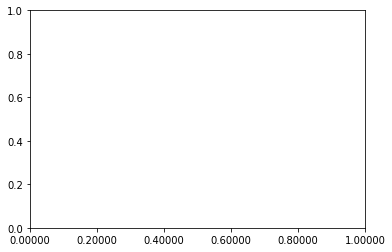

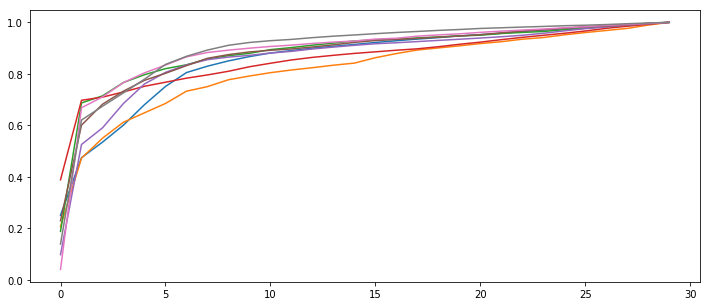

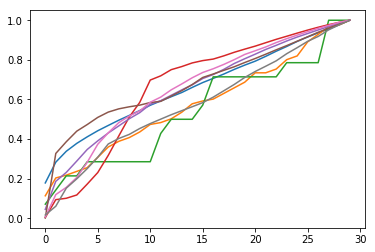

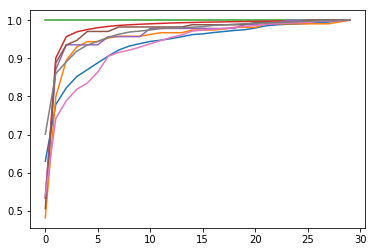

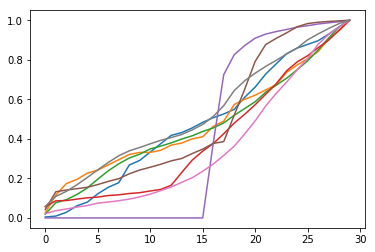

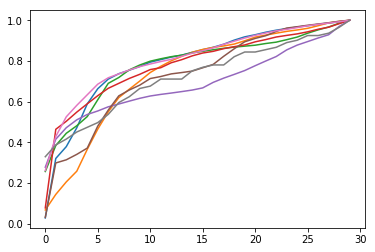

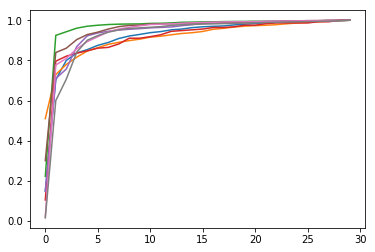

In [65]:
EXAMPLES_COUNT = 8

for i in range(CLUSTERS_COUNT):
    classInd = np.where(kmeans.labels_ == i)[0]

    for y in range(EXAMPLES_COUNT):
        plt.plot(train_inputs[classInd[y]])
    plt.show()


In [67]:
CLUSTERS_COUNT = 6
EXAMPLES_COUNT = 8

train_inputs, train_lables = ExtractSequenes(trainViewsD, seqLength = 360, lableShift, minLimit, maxLimit)

#train_inputs = ExtractNormilizedSequences(trainViewsD, seqLength, minLimit, maxLimit)
kmeans = KMeans(n_clusters=CLUSTERS_COUNT, random_state=0).fit(trainViewsD)

for i in range(CLUSTERS_COUNT):
    classInd = np.where(kmeans.labels_ == i)[0]

    for y in range(EXAMPLES_COUNT):
        plt.plot(train_inputs[classInd[y]])
    plt.show()

ValueError: setting an array element with a sequence.

In [ ]:
for i in range(CLUSTERS_COUNT):
    menVals = np.mean(train_inputs[np.where(kmeans.labels_ == i)[0]], axis = 0)
    plt.plot(menVals)
    plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

aggl = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(train_inputs)


In [ ]:
aggl.labels_


In [ ]:
for i in range(np.max(aggl.labels_)):
    menVals = np.mean(train_inputs[np.where(kmeans.labels_ == i)[0]], axis = 0)
    plt.plot(menVals)
    plt.show()

In [ ]:
minLimit = 360
seqLength = 360
maxLimit = 100000
train_inputs = np.array(ExtractNormilizedSequences(trainViewsD, seqLength, minLimit, maxLimit))

In [ ]:
CLUSTERS_COUNT = 4
kmeans = KMeans(n_clusters=CLUSTERS_COUNT, random_state=0).fit(train_inputs)

def PrintClusterExamples(clusterid, examplesCount = 10):
    for i in range(examplesCount):
        classInd = np.where(kmeans.labels_ == 0)[0]
        plt.plot(train_inputs[classInd[i]])
    plt.show()

In [ ]:
for i in range(CLUSTERS_COUNT):
    menVals = np.mean(train_inputs[np.where(kmeans.labels_ == i)[0]], axis = 0)
    plt.plot(menVals)
    plt.show()

In [ ]:
train_inputs

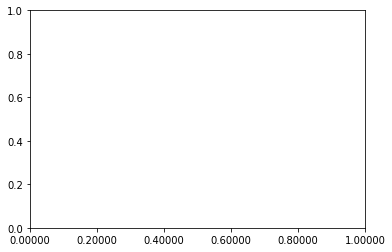

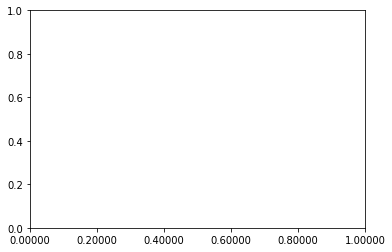

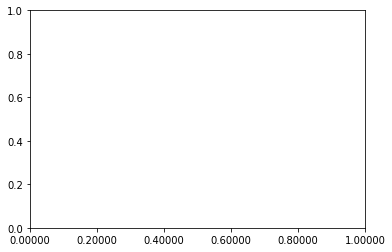

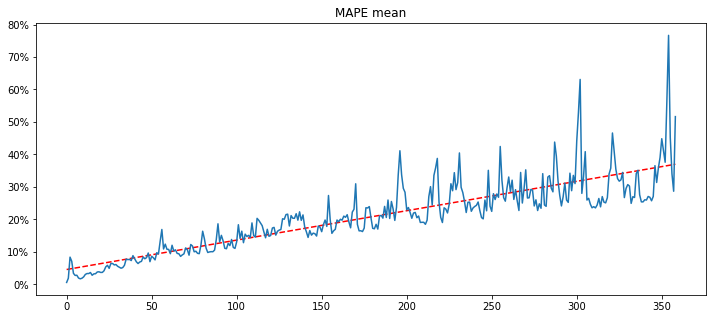

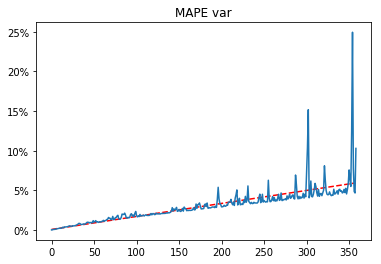

Min at index: 0; val: 0.0%


In [59]:
dSeqPred_oneD = TestSeqPredDeltaPerf(trainViewsD, testViewsD, seqLen = 1,
                                    maxPredDelta = 360, predDeltaStep = 1, minLimit = 360, maxLimit = None)
Plot(dSeqPred_oneD)